Rozmiar zbioru danych: (16598, 11)

Pierwsze 5 wierszy:
Informacje o zbiorze danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB

Statystyki opisowe:
Brakujące dane:
           Brakujące   Procent
Year             271  1.632727
Publisher         58  0.349440
Liczba rekordów po czyszczeniu: 15945
Liczba outlierów:

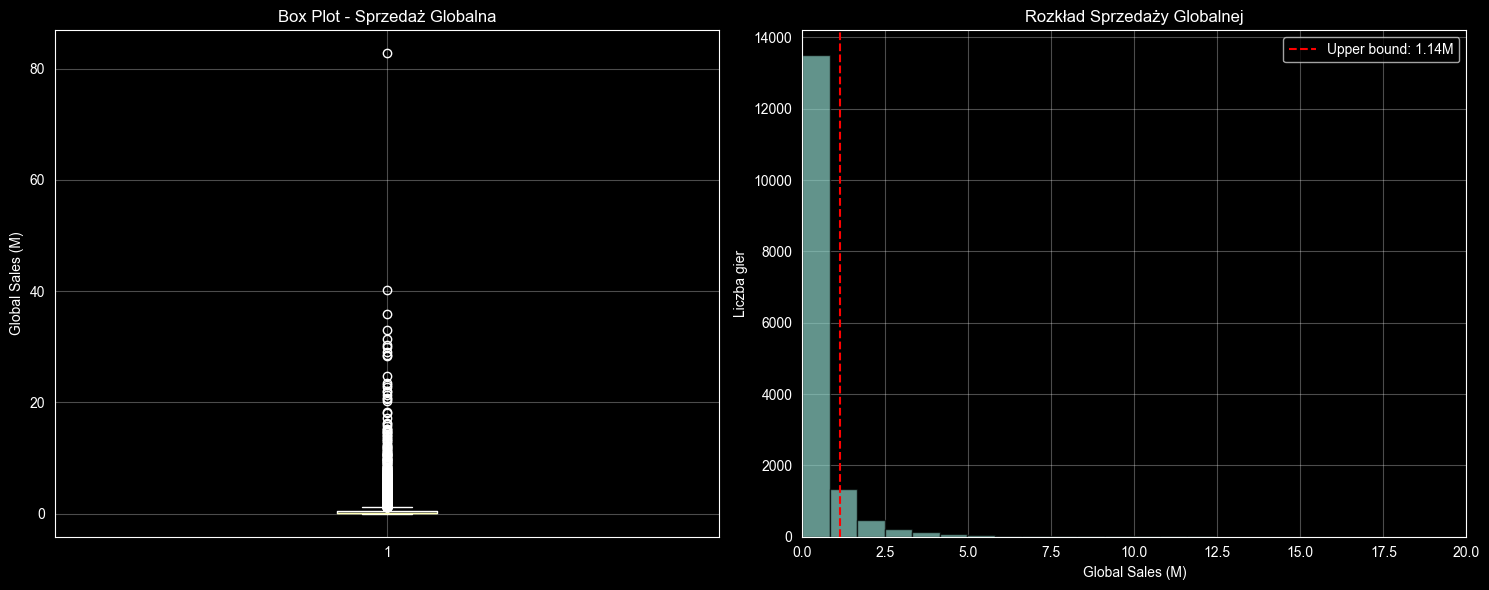

Gry bez outlierów: 14178
Gry-outliery (bestsellery): 1767

Top 10 bestsellerów:
                        Name  Year Platform  Global_Sales
0                 Wii Sports  2006      Wii         82.74
1          Super Mario Bros.  1985      NES         40.24
2             Mario Kart Wii  2008      Wii         35.82
3          Wii Sports Resort  2009      Wii         33.00
4   Pokemon Red/Pokemon Blue  1996       GB         31.37
5                     Tetris  1989       GB         30.26
6      New Super Mario Bros.  2006       DS         30.01
7                   Wii Play  2006      Wii         29.02
8  New Super Mario Bros. Wii  2009      Wii         28.62
9                  Duck Hunt  1984      NES         28.31


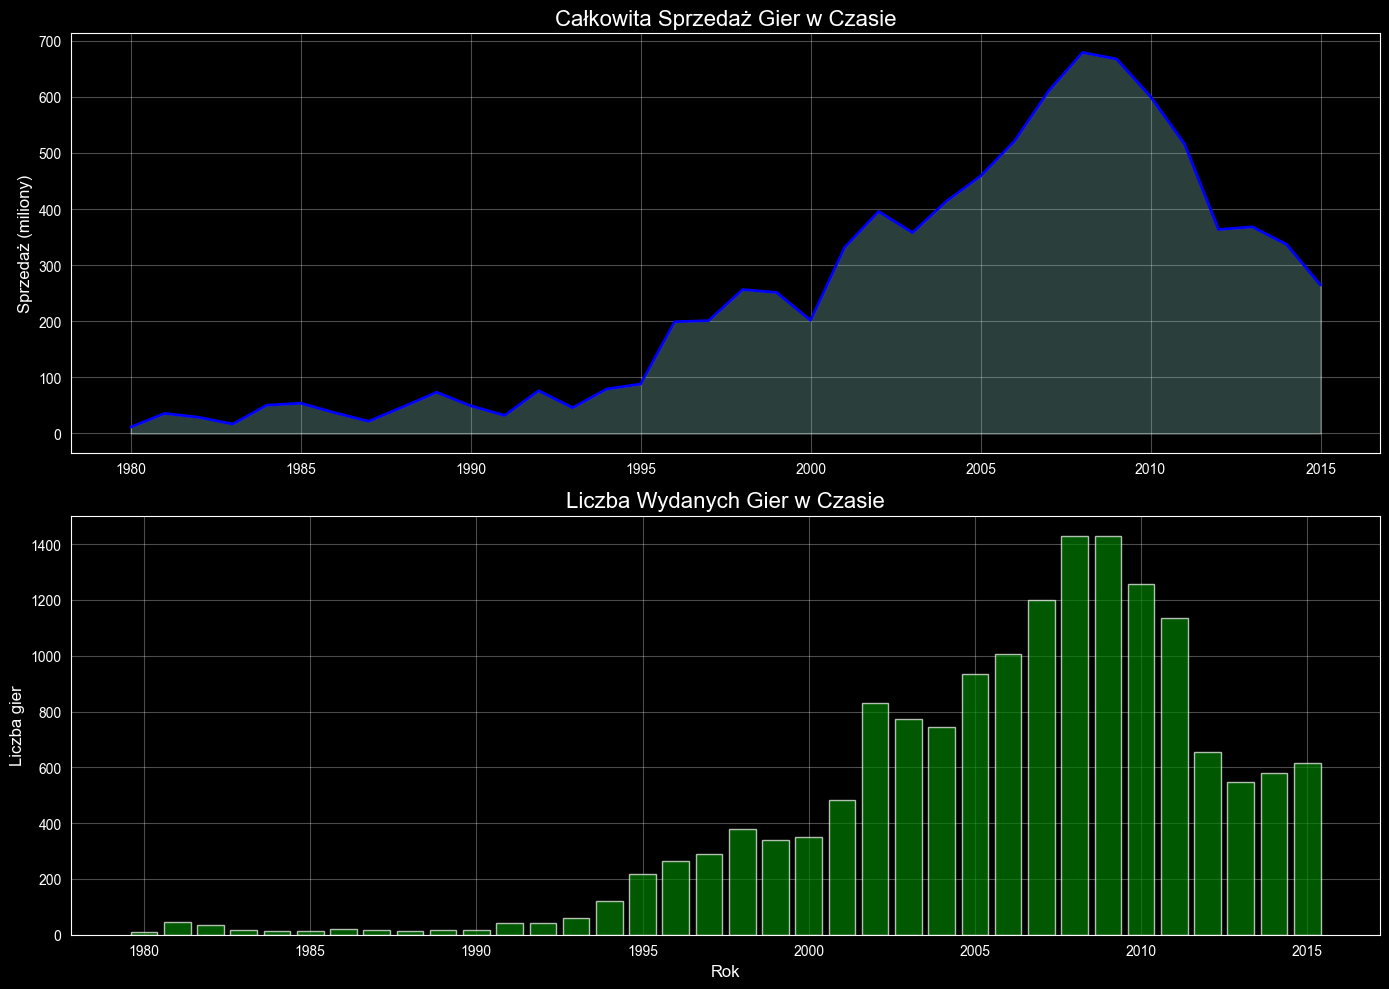

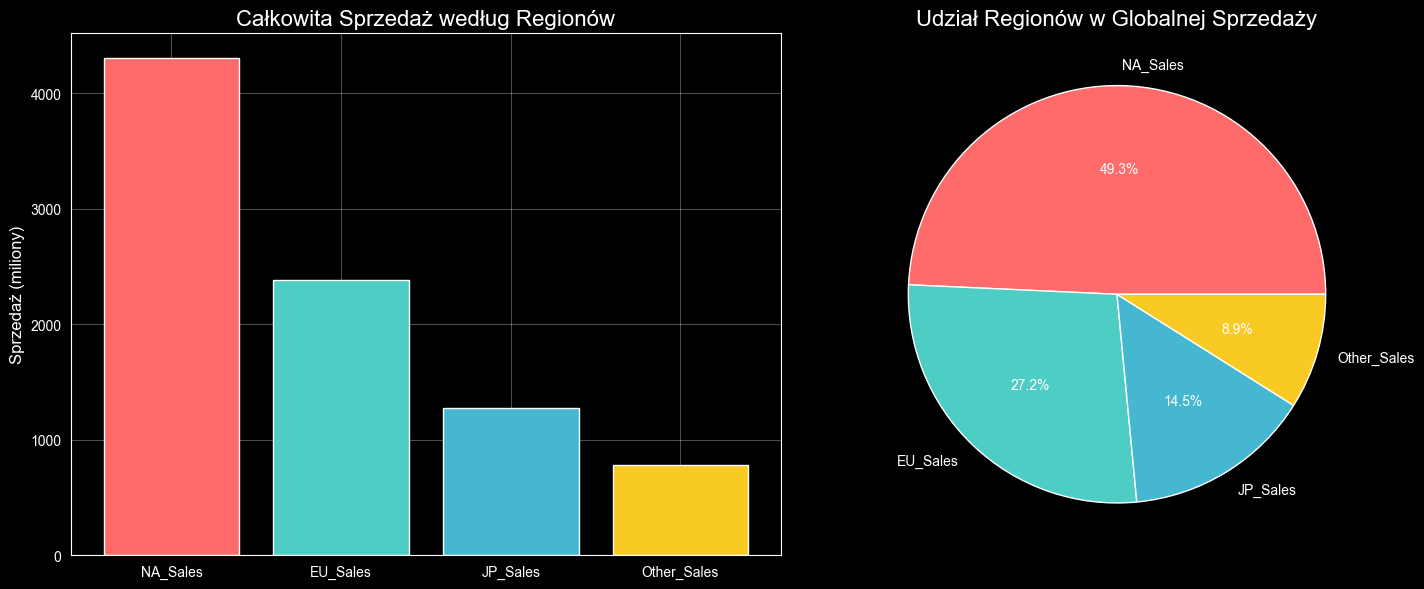

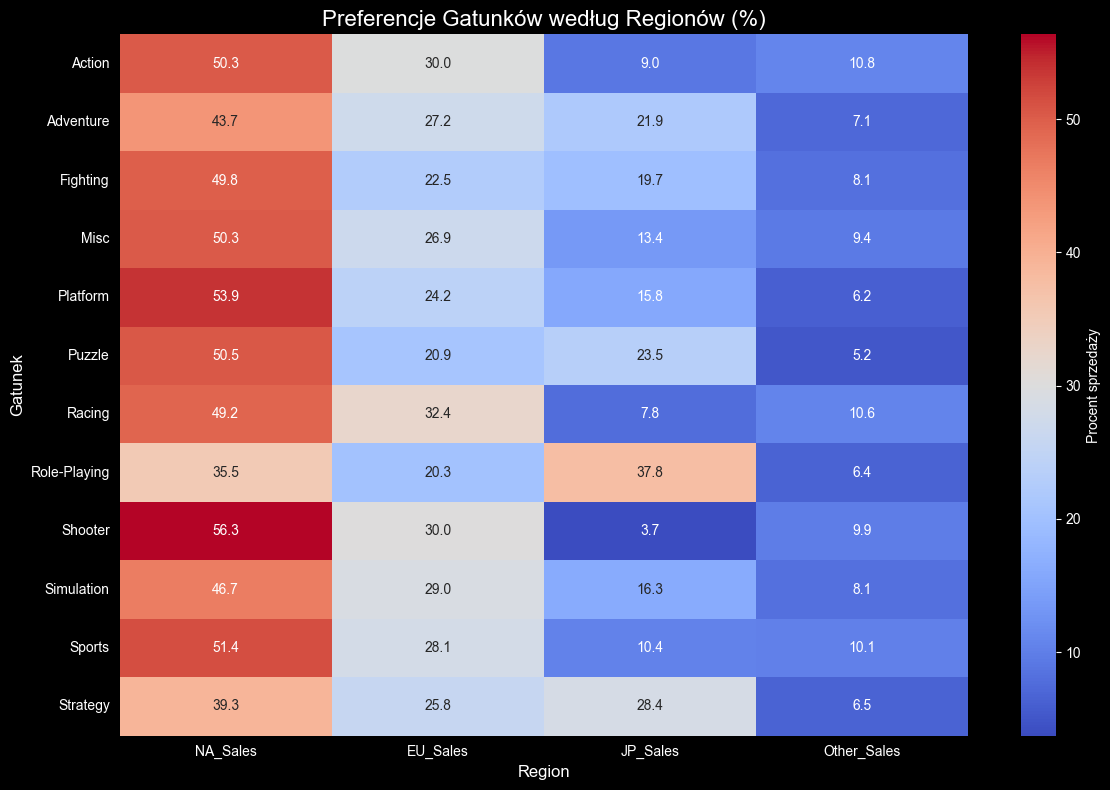

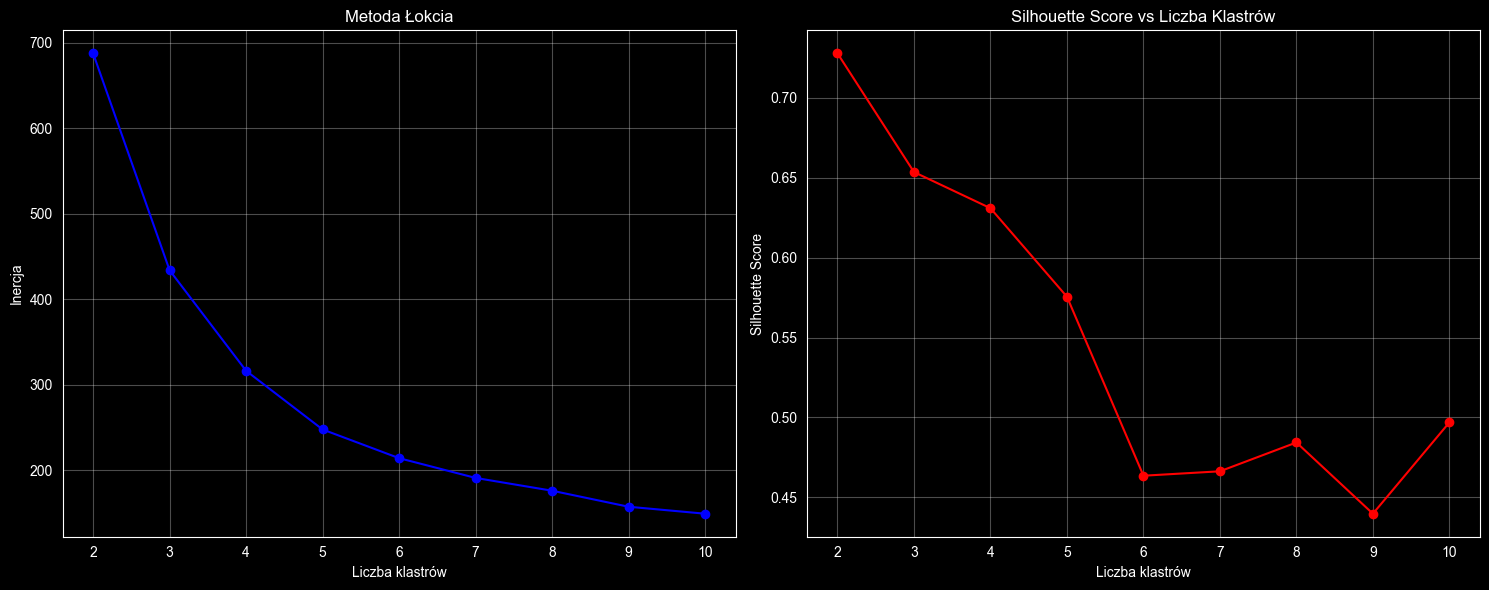

Charakterystyka klastrów:
         Global_Sales    NA_Sales   EU_Sales   JP_Sales  Game_Count
Cluster                                                            
0            8.246857    4.047619   1.801190   1.910286   19.871429
1          125.272857   61.973571  38.235000  11.530714  224.571429
2          265.985714  136.808571  79.802857  16.695714  305.285714
3           50.439423   25.991923  15.125769   4.875577  106.653846
4           77.032000   27.785000  12.123000  33.756000   94.500000


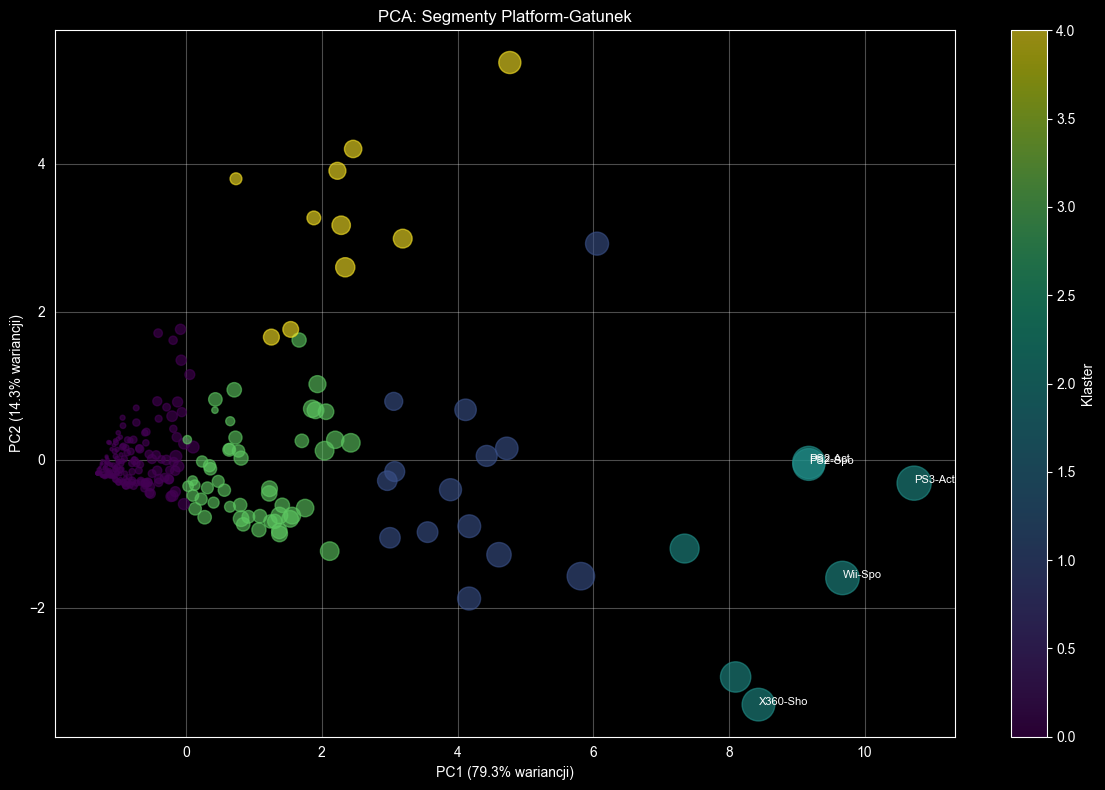

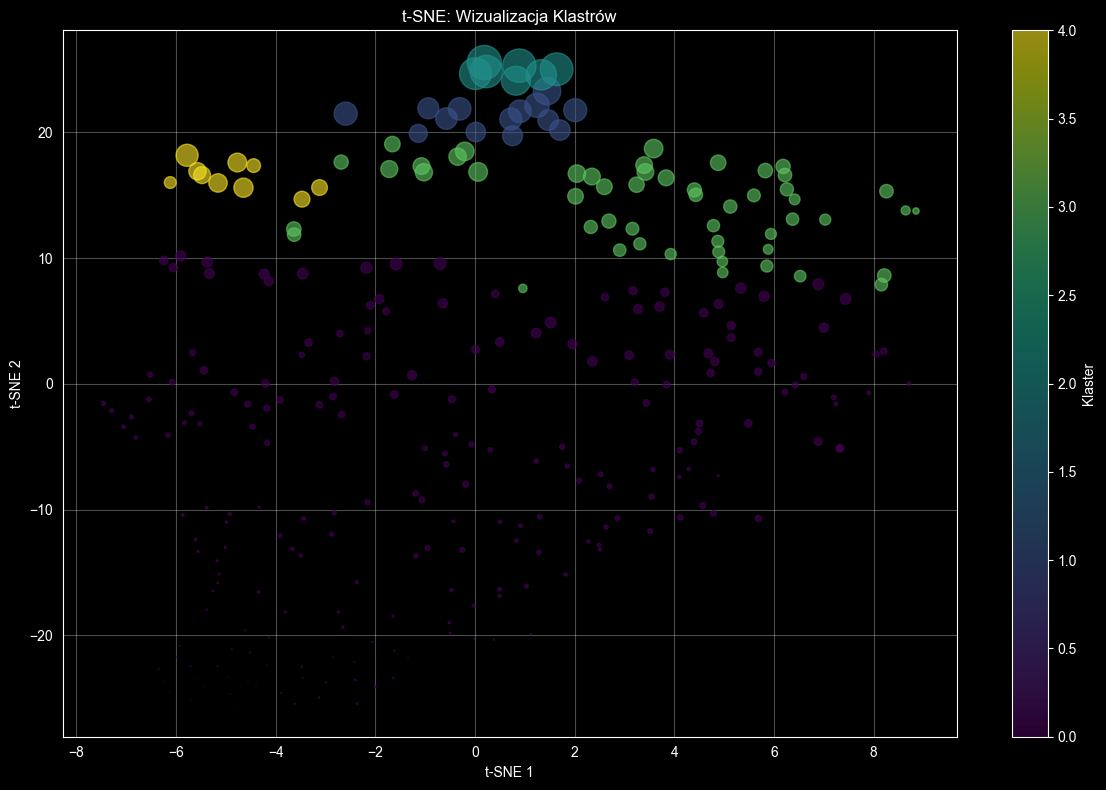

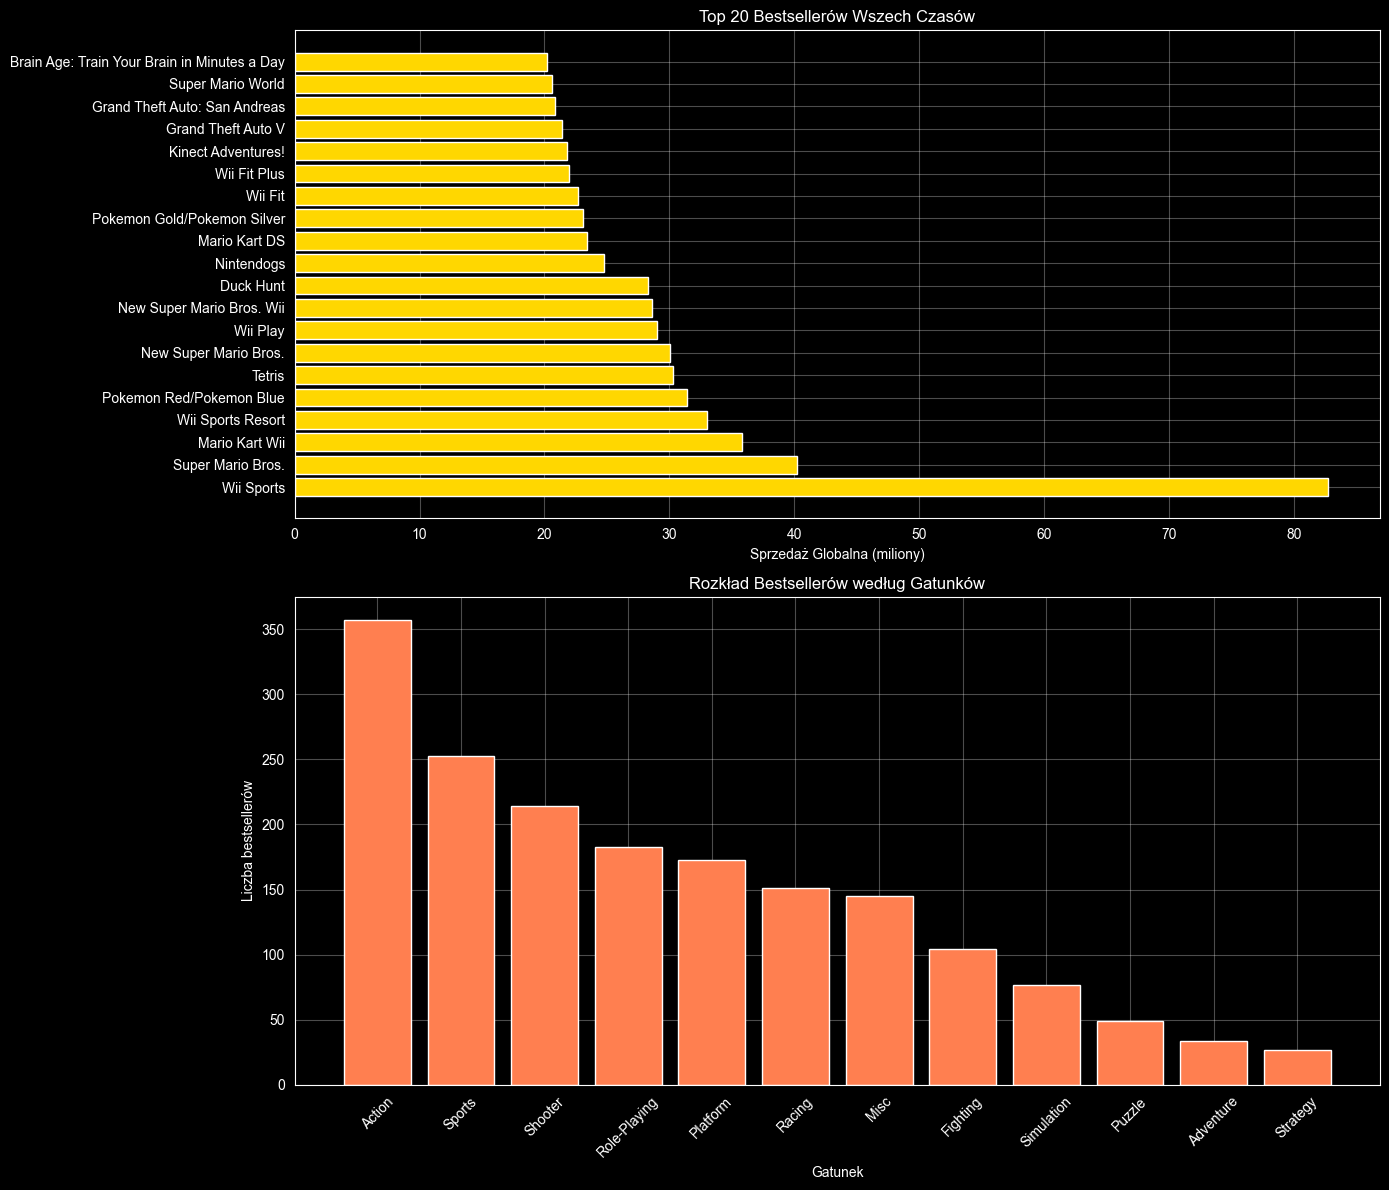

Analiza zakończona!
Przeanalizowano 15945 gier z lat 1980-2015
Zidentyfikowano 5 głównych segmentów rynku
Wykryto 1767 gier-bestsellerów stanowiących outliery


In [2]:
# %% [markdown]
# # Analiza Ewolucji Globalnego Rynku Gier Wideo (1980-2015)
# 
# ## Spis treści
# 1. Wczytanie i wstępna eksploracja danych
# 2. Czyszczenie danych i obsługa outlierów
# 3. Analiza trendów czasowych
# 4. Analiza regionalna
# 5. Segmentacja rynku (clustering)
# 6. Redukcja wymiarowości (PCA, t-SNE)
# 7. Wnioski i rekomendacje

# %% [markdown]
# ## 1. Wczytanie i konfiguracja środowiska

# %%
# Importowanie bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Konfiguracja
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
pd.set_option('display.max_columns', None)

# %% [markdown]
# ## 2. Wczytanie i wstępna eksploracja danych

# %%
# Wczytanie danych
df = pd.read_csv('video games sales.csv')

# Podstawowe informacje o zbiorze
print("Rozmiar zbioru danych:", df.shape)
print("\nPierwsze 5 wierszy:")
df.head()

# %%
# Informacje o typach danych i brakujących wartościach
print("Informacje o zbiorze danych:")
df.info()
print("\nStatystyki opisowe:")
df.describe()

# %%
# Analiza brakujących danych
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Brakujące': missing_data,
    'Procent': missing_percent
})
missing_df = missing_df[missing_df['Brakujące'] > 0].sort_values('Procent', ascending=False)
print("Brakujące dane:")
print(missing_df)

# %% [markdown]
# ## 3. Czyszczenie danych i obsługa outlierów

# %%
# Usunięcie wierszy z brakującymi kluczowymi danymi
df_clean = df.dropna(subset=['Year', 'Publisher'])

# Konwersja roku na int
df_clean['Year'] = df_clean['Year'].astype(int)

# Ograniczenie do lat 1980-2015 (zgodnie z założeniami projektu)
df_clean = df_clean[(df_clean['Year'] >= 1980) & (df_clean['Year'] <= 2015)]

print(f"Liczba rekordów po czyszczeniu: {len(df_clean)}")

# %%
# Identyfikacja outlierów używając metody IQR
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analiza outlierów dla sprzedaży globalnej
outliers, lower, upper = identify_outliers(df_clean, 'Global_Sales')
print(f"Liczba outlierów: {len(outliers)}")
print(f"Procent outlierów: {len(outliers)/len(df_clean)*100:.2f}%")
print(f"Granice: [{lower:.2f}, {upper:.2f}]")

# %%
# Wizualizacja outlierów
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot
ax1.boxplot(df_clean['Global_Sales'], vert=True)
ax1.set_title('Box Plot - Sprzedaż Globalna')
ax1.set_ylabel('Global Sales (M)')
ax1.grid(True, alpha=0.3)

# Histogram z zaznaczonymi granicami
ax2.hist(df_clean['Global_Sales'], bins=100, edgecolor='black', alpha=0.7)
ax2.axvline(x=upper, color='red', linestyle='--', label=f'Upper bound: {upper:.2f}M')
ax2.set_title('Rozkład Sprzedaży Globalnej')
ax2.set_xlabel('Global Sales (M)')
ax2.set_ylabel('Liczba gier')
ax2.set_xlim(0, 20)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Podział danych na outliers i non-outliers dla dalszej analizy
df_no_outliers = df_clean[df_clean['Global_Sales'] <= upper]
df_outliers = df_clean[df_clean['Global_Sales'] > upper]

print(f"Gry bez outlierów: {len(df_no_outliers)}")
print(f"Gry-outliery (bestsellery): {len(df_outliers)}")
print("\nTop 10 bestsellerów:")
print(df_outliers.nlargest(10, 'Global_Sales')[['Name', 'Year', 'Platform', 'Global_Sales']])

# %% [markdown]
# ## 4. Analiza trendów czasowych

# %%
# Trendy sprzedaży w czasie
yearly_sales = df_clean.groupby('Year')['Global_Sales'].agg(['sum', 'mean', 'count'])
yearly_sales.columns = ['Total_Sales', 'Avg_Sales', 'Game_Count']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Całkowita sprzedaż
ax1.plot(yearly_sales.index, yearly_sales['Total_Sales'], 'b-', linewidth=2)
ax1.fill_between(yearly_sales.index, yearly_sales['Total_Sales'], alpha=0.3)
ax1.set_title('Całkowita Sprzedaż Gier w Czasie', fontsize=16)
ax1.set_ylabel('Sprzedaż (miliony)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Liczba wydanych gier
ax2.bar(yearly_sales.index, yearly_sales['Game_Count'], color='green', alpha=0.7)
ax2.set_title('Liczba Wydanych Gier w Czasie', fontsize=16)
ax2.set_xlabel('Rok', fontsize=12)
ax2.set_ylabel('Liczba gier', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Ewolucja platform w czasie
platform_evolution = df_clean.groupby(['Year', 'Platform'])['Global_Sales'].sum().reset_index()
top_platforms = df_clean.groupby('Platform')['Global_Sales'].sum().nlargest(10).index

# Interaktywny wykres
fig = px.area(platform_evolution[platform_evolution['Platform'].isin(top_platforms)], 
              x='Year', y='Global_Sales', color='Platform',
              title='Ewolucja Platform w Czasie (Top 10)',
              labels={'Global_Sales': 'Sprzedaż (miliony)'},
              template='plotly_dark')
fig.update_layout(height=600)
fig.show()

# %% [markdown]
# ## 5. Analiza regionalna

# %%
# Porównanie sprzedaży regionalnej
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
regional_totals = df_clean[regions].sum().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Wykres słupkowy
ax1.bar(regional_totals.index, regional_totals.values, 
        color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9ca24'])
ax1.set_title('Całkowita Sprzedaż według Regionów', fontsize=16)
ax1.set_ylabel('Sprzedaż (miliony)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Wykres kołowy
ax2.pie(regional_totals.values, labels=regional_totals.index, autopct='%1.1f%%',
        colors=['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9ca24'])
ax2.set_title('Udział Regionów w Globalnej Sprzedaży', fontsize=16)

plt.tight_layout()
plt.show()

# %%
# Heatmapa: Gatunki vs Regiony
genre_region = df_clean.groupby('Genre')[regions].sum()
genre_region_normalized = genre_region.div(genre_region.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 8))
sns.heatmap(genre_region_normalized, annot=True, fmt='.1f', cmap='coolwarm', 
            cbar_kws={'label': 'Procent sprzedaży'})
plt.title('Preferencje Gatunków według Regionów (%)', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Gatunek', fontsize=12)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 6. Segmentacja rynku (Clustering)

# %%
# Przygotowanie danych do klastrowania
# Agregacja na poziomie Platform-Gatunek
platform_genre = df_clean.groupby(['Platform', 'Genre']).agg({
    'Global_Sales': 'sum',
    'NA_Sales': 'sum',
    'EU_Sales': 'sum',
    'JP_Sales': 'sum',
    'Name': 'count'
}).reset_index()
platform_genre.columns = ['Platform', 'Genre', 'Global_Sales', 'NA_Sales', 
                         'EU_Sales', 'JP_Sales', 'Game_Count']

# Normalizacja danych
features = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Game_Count']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(platform_genre[features])

# %%
# Metoda łokcia
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Wykres łokcia
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Liczba klastrów')
ax1.set_ylabel('Inercja')
ax1.set_title('Metoda Łokcia')
ax1.grid(True, alpha=0.3)

# Silhouette score
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Liczba klastrów')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Liczba Klastrów')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Klastrowanie K-means z optymalną liczbą klastrów
optimal_k = 5  # Na podstawie analizy łokcia i silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
platform_genre['Cluster'] = kmeans.fit_predict(X_scaled)

# Analiza klastrów
cluster_summary = platform_genre.groupby('Cluster')[features].mean()
print("Charakterystyka klastrów:")
print(cluster_summary)

# %% [markdown]
# ## 7. Redukcja wymiarowości i wizualizacja

# %%
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Wizualizacja PCA z klastrami
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=platform_genre['Cluster'], 
                     s=platform_genre['Global_Sales']*2,
                     cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Klaster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} wariancji)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} wariancji)')
plt.title('PCA: Segmenty Platform-Gatunek')

# Dodanie etykiet dla największych punktów
top_segments = platform_genre.nlargest(5, 'Global_Sales')
for idx in top_segments.index:
    plt.annotate(f"{platform_genre.loc[idx, 'Platform']}-{platform_genre.loc[idx, 'Genre'][:3]}", 
                (X_pca[idx, 0], X_pca[idx, 1]), fontsize=8)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Wizualizacja t-SNE
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     c=platform_genre['Cluster'], 
                     s=platform_genre['Global_Sales']*2,
                     cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Klaster')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE: Wizualizacja Klastrów')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 8. Analiza bestsellerów i wzorców sukcesu

# %%
# Charakterystyka bestsellerów (outlierów)
bestsellers = df_outliers.copy()

# Top 20 bestsellerów
top20 = bestsellers.nlargest(20, 'Global_Sales')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Wykres słupkowy top 20
ax1.barh(top20['Name'], top20['Global_Sales'], color='gold')
ax1.set_xlabel('Sprzedaż Globalna (miliony)')
ax1.set_title('Top 20 Bestsellerów Wszech Czasów')
ax1.grid(True, alpha=0.3)

# Rozkład bestsellerów według gatunków
genre_bestsellers = bestsellers['Genre'].value_counts()
ax2.bar(genre_bestsellers.index, genre_bestsellers.values, color='coral')
ax2.set_xlabel('Gatunek')
ax2.set_ylabel('Liczba bestsellerów')
ax2.set_title('Rozkład Bestsellerów według Gatunków')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Analiza wydawców
top_publishers = df_clean.groupby('Publisher').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).sort_values('Global_Sales', ascending=False).head(15)

top_publishers.columns = ['Total_Sales', 'Game_Count']
top_publishers['Avg_Sales_per_Game'] = top_publishers['Total_Sales'] / top_publishers['Game_Count']

# Wizualizacja
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_publishers.index,
    y=top_publishers['Total_Sales'],
    name='Całkowita sprzedaż',
    marker_color='lightblue'
))

fig.add_trace(go.Scatter(
    x=top_publishers.index,
    y=top_publishers['Avg_Sales_per_Game'],
    mode='lines+markers',
    name='Średnia sprzedaż na grę',
    yaxis='y2',
    marker_color='red'
))

fig.update_layout(
    title='Top 15 Wydawców: Całkowita Sprzedaż vs Średnia na Grę',
    xaxis_tickangle=-45,
    yaxis=dict(title='Całkowita sprzedaż (miliony)'),
    yaxis2=dict(title='Średnia sprzedaż na grę (miliony)', overlaying='y', side='right'),
    template='plotly_dark',
    height=600
)

fig.show()

# %% [markdown]
# ## 9. Podsumowanie kluczowych odkryć

# %%
# Tworzenie dashboardu z kluczowymi metrykami
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Rozkład Sprzedaży', 'Dominujące Platformy', 
                    'Trendy Gatunków', 'Segmentacja Rynku'),
    specs=[[{'type': 'histogram'}, {'type': 'bar'}],
           [{'type': 'scatter'}, {'type': 'pie'}]]
)

# 1. Histogram sprzedaży
fig.add_trace(
    go.Histogram(x=df_no_outliers['Global_Sales'], nbinsx=50, name='Sprzedaż'),
    row=1, col=1
)

# 2. Top platformy
top_platforms_data = df_clean.groupby('Platform')['Global_Sales'].sum().nlargest(10)
fig.add_trace(
    go.Bar(x=top_platforms_data.values, y=top_platforms_data.index, 
           orientation='h', name='Platformy'),
    row=1, col=2
)

# 3. Trendy gatunków w czasie
genre_trends = df_clean.groupby(['Year', 'Genre'])['Global_Sales'].sum().reset_index()
for genre in df_clean['Genre'].value_counts().head(5).index:
    genre_data = genre_trends[genre_trends['Genre'] == genre]
    fig.add_trace(
        go.Scatter(x=genre_data['Year'], y=genre_data['Global_Sales'], 
                  mode='lines', name=genre),
        row=2, col=1
    )

# 4. Udział klastrów
cluster_sizes = platform_genre['Cluster'].value_counts()
fig.add_trace(
    go.Pie(labels=[f'Klaster {i}' for i in cluster_sizes.index], 
           values=cluster_sizes.values),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=True, template='plotly_dark',
                  title_text="Dashboard: Kluczowe Metryki Rynku Gier")
fig.show()

# %%
# Zapisanie oczyszczonych danych
df_clean.to_csv('vgsales_clean.csv', index=False)
platform_genre.to_csv('platform_genre_clusters.csv', index=False)

print("Analiza zakończona!")
print(f"Przeanalizowano {len(df_clean)} gier z lat {df_clean['Year'].min()}-{df_clean['Year'].max()}")
print(f"Zidentyfikowano {optimal_k} głównych segmentów rynku")
print(f"Wykryto {len(df_outliers)} gier-bestsellerów stanowiących outliery")